In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from keras.utils.np_utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler 
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Using TensorFlow backend.
C:\Users\sed\anaconda3\envs\python-cvcourse\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# load train data
train_data =np.load('numpy_files/age_train.npz')
X_train =train_data['X']
y_train =train_data['y']

# load test data
test_data =np.load('numpy_files/age_test.npz')

# split into X & Y
X_test =test_data['X_test']
y_test =test_data['y_test']

# Create a dataframe with the Y data
y_df = pd.DataFrame(y_test)

# load the trained model
model = load_model('age_estimator.h5')

In [4]:
#y_df.value_counts().sort_index()
indi =np.argmax(to_categorical(y_df),axis=1,)

new_df = pd.DataFrame(indi)
new_df[1].value_counts().sort_index()

0    112
1    120
2     72
3    849
4    355
5     92
Name: 1, dtype: int64

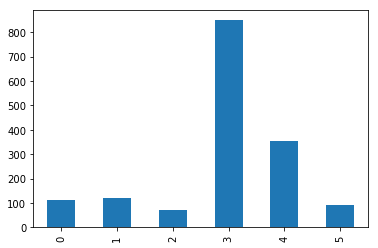

In [5]:
new_df[1].value_counts().sort_index().plot(kind ='bar')

When observing the var graph above it is clear to see that there is a a large majority of images that are classified as class three (Adults between 20 and 40) the second largest is class 4 (adults between 40 and 65).There are far fewer people under 20 and over 65. This imbalance in data can lead to a potential classifier bias towards the majority classes.

## Classify test data using model

In [6]:
y_pred = model.predict_classes(X_test)
y_cat= to_categorical(y_pred,6)
print(f"Accuracy: {accuracy_score(y_cat,y_test)}")
print(f"Classification Report: \n{classification_report(y_cat,y_test)}")

Accuracy: 0.765
Classification Report: 
             precision    recall  f1-score   support

          0       0.85      0.85      0.85       112
          1       0.52      0.76      0.61        82
          2       0.28      0.47      0.35        43
          3       0.92      0.79      0.85       980
          4       0.59      0.71      0.64       296
          5       0.64      0.68      0.66        87

avg / total       0.80      0.77      0.78      1600



When observing the results above the classifier bias is fairly obvious when looking at the recall values as class 2 is predicted with the lowest frequency. The large size of class 3 is also refelected in the precision in which it is estimated. It is interesting to note that all though class 0 had the second smallest data set it achieved the joint highest f1-score. While class 4 which was the second largest dataset achived a poorer f1-score than classes 5 and zero which were both smallers datasets. 

## Reducing imbalanced datasets
There are a number of methods to reduce the imbalance throughout the entire dataset.

- Undersampling to randomly reducing the the number of images in class 3 and 4.


- Adding a new class to break up class 3 so there would be 7 classes in total


- Conduct data augmentation by manipulating the existing images to create new similar images thus increasing the datset size for the smaller datasets. 

In [7]:
# Load the X and y data
age_data = np.load('numpy_files/age_data.npz')
X_data = age_data['X']
y_data = age_data['y']


# Normalise the data
X_data = X_data/255

## Split data into train and test

In [8]:
# Split data to small size for parameter testing
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.30, random_state=42)

In [9]:
X_train.shape

(16596, 50, 50, 3)

# Random Undersampling

The imbalance learn module will be used to reduce the size of the majority class in this case class 3.

In [10]:
def reduce_majority(X,y,cls=3):
    """ reduce the majority class data by half """
    X_under = []
    y_under = []
    maj_ttl = 0
    for i, face in enumerate(X):
        age = y[i]
        if age ==cls:
            maj_ttl+=1
            if maj_ttl%2 ==0:
                X_under.append(face)
                y_under.append(age)
        else:
            X_under.append(face)
            y_under.append(age)
            
    X_under=np.array(X_under)
    y_under = np.array(y_under)
    return X_under,y_under

In [11]:
X_under,y_under =reduce_majority(X_train,y_train,cls=3)

In [12]:
X_under.shape

(12452, 50, 50, 3)

In [13]:
y_full = pd.DataFrame(y_data)
y_full[0].value_counts().sort_index()

0     1605
1     1808
2     1180
3    11881
4     5536
5     1699
Name: 0, dtype: int64

In [14]:
y_samp = pd.DataFrame(y_under)
y_samp[0].value_counts().sort_index()

0    1118
1    1286
2     848
3    4143
4    3867
5    1190
Name: 0, dtype: int64

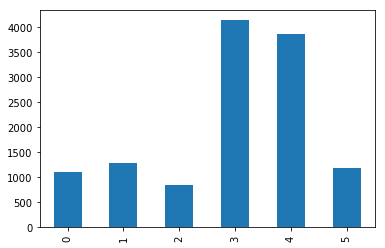

In [15]:
y_samp[0].value_counts().sort_index().plot(kind ='bar')

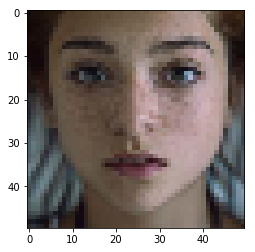

In [16]:
plt.imshow(X_under[0])

In [17]:
# Catgorise the y data
y_under_cat = to_categorical(y_under,6)
y_test = to_categorical(y_test,6)

In [18]:
y_under[0]

2

In [19]:
X_test.shape

(7113, 50, 50, 3)

In [20]:
# Select data for validation
X_valid = X_test[6613:]
y_valid = y_test[6613:]

X_test = X_test[:6613]
y_test = y_test[:6613]
X_test.shape

(6613, 50, 50, 3)

In [21]:
# Optimizer tuning
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=2,input_shape=(50,50,3), activation='linear'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=2,input_shape=(50,50,3), activation='linear'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(filters=64, kernel_size=2,input_shape=(50,50,3), activation='linear'))
    model.add(MaxPooling2D(pool_size=2))

    # flatten array to 50*50
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('linear'))
    
    # Prevent overfitting 
    model.add(Dropout(0.4))
    model.add(Dense(6))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    return model

In [22]:
model =create_model()
model.fit(X_under,
         y_under_cat,
         batch_size=64,
         epochs=10,
         validation_data=(X_valid, y_valid))

y_pred = model.predict_classes(X_test)
y_cat= to_categorical(y_pred,6)
print(f"Accuracy: {accuracy_score(y_cat,y_test)}")
print(f"Classification Report: \n{classification_report(y_cat,y_test)}")

Train on 12452 samples, validate on 500 samples
Epoch 1/10
12452/12452 [==============================] - 12s 934us/step - loss: 1.1572 - acc: 0.5399 - val_loss: 0.9060 - val_acc: 0.6360
Epoch 2/10
12452/12452 [==============================] - 11s 863us/step - loss: 0.8867 - acc: 0.6409 - val_loss: 0.7676 - val_acc: 0.6620
Epoch 3/10
12452/12452 [==============================] - 11s 885us/step - loss: 0.7933 - acc: 0.6770 - val_loss: 0.7088 - val_acc: 0.7020
Epoch 4/10
12452/12452 [==============================] - 12s 935us/step - loss: 0.7420 - acc: 0.7000 - val_loss: 0.7782 - val_acc: 0.6520
Epoch 5/10
12452/12452 [==============================] - 12s 934us/step - loss: 0.6871 - acc: 0.7251 - val_loss: 0.6514 - val_acc: 0.7200
Epoch 6/10
12452/12452 [==============================] - 11s 904us/step - loss: 0.6492 - acc: 0.7372 - val_loss: 0.6707 - val_acc: 0.6920
Epoch 7/10
12452/12452 [==============================] - 11s 892us/step - loss: 0.6099 - acc: 0.7539 - val_loss: 0.63

When the majority class is reduced there is an overall reduce in the accuracy from 0.765 to 0.708. There was also a reduction of the f1-score from 0.78 to 0.70. With the largest fall evident in the reduction in f1-score of class 3 from 0.85 to 0.79. There was however a small improvement in f1-scores for class 1,2 and 4. a small reduction was seen in the f1-score of class 5.

## Data augmentation

In [23]:
from keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range=15, # rotate the image 30 degrees
                               width_shift_range=0.1, # Shift the pic width by a max of 10%
                               height_shift_range=0.1, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [24]:
def augment_minority(X,y,iterations=1,majority_classes=[3,4]):
    """ Augment the images to add new images """
    # Store augmented images
    X_aug = []
    y_aug = []
    for i in range(iterations):
        for j, face in enumerate(X):
            
            # Only augment the minority classes
            age = y[j]
            if age not in majority_classes:
                # randomly trasnform the image
                img = image_gen.random_transform(face)
                X_aug.append(img)
                y_aug.append(age)

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    return X_aug,y_aug



In [25]:
X_aug,y_aug= augment_minority(X_train,y_train)

In [26]:
X_aug.shape,y_aug.shape

((4442, 50, 50, 3), (4442,))

In [27]:
X_over = np.concatenate((X_train,X_aug))
y_over = np.concatenate((y_train,y_aug))

In [28]:
X_over.shape,y_over.shape

((21038, 50, 50, 3), (21038,))

In [29]:
y_over_df =pd.DataFrame(y_over)

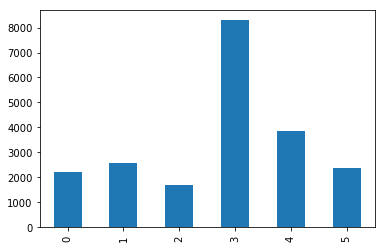

In [30]:
y_over_df[0].value_counts().sort_index().plot(kind ='bar')

In [31]:
# Catgorise the y data
y_over_cat = to_categorical(y_over,6)

In [32]:
model =create_model()
model.fit(X_over,
         y_over_cat,
         batch_size=64,
         epochs=10,
         validation_data=(X_valid, y_valid))

y_pred = model.predict_classes(X_test)
y_cat= to_categorical(y_pred,6)
print(f"Accuracy: {accuracy_score(y_cat,y_test)}")
print(f"Classification Report: \n{classification_report(y_cat,y_test)}")

Train on 21038 samples, validate on 500 samples
Epoch 1/10
21038/21038 [==============================] - 20s 940us/step - loss: 1.1378 - acc: 0.5632 - val_loss: 0.8325 - val_acc: 0.6780
Epoch 2/10
21038/21038 [==============================] - 20s 927us/step - loss: 0.8424 - acc: 0.6725 - val_loss: 0.7083 - val_acc: 0.7320
Epoch 3/10
21038/21038 [==============================] - 19s 899us/step - loss: 0.7440 - acc: 0.7085 - val_loss: 0.6762 - val_acc: 0.7300
Epoch 4/10
21038/21038 [==============================] - 19s 922us/step - loss: 0.6865 - acc: 0.7318 - val_loss: 0.6535 - val_acc: 0.7380
Epoch 5/10
21038/21038 [==============================] - 20s 968us/step - loss: 0.6348 - acc: 0.7526 - val_loss: 0.6651 - val_acc: 0.7500
Epoch 6/10
21038/21038 [==============================] - 20s 960us/step - loss: 0.5972 - acc: 0.7645 - val_loss: 0.6311 - val_acc: 0.7460
Epoch 7/10
21038/21038 [==============================] - 20s 943us/step - loss: 0.5730 - acc: 0.7705 - val_loss: 0.67

When comparing the above model with over sampling it achieves a poore accuracy than the original model  with a fall from 0.765 to 0.746. The f1-scores of classes 3 and 4 have fallen. 

when compared to the undersampled model the accuracy is superior with 0.708 and 0.746 respectively. 

In [33]:
model.save('age_classifier_oversampled.h5')

### Increase number of Augmented images

In [34]:
# Augment in range 2
X_aug1,y_aug1= augment_minority(X_train,y_train,iterations=1)

# Augment for class 2 the minority class only
X_aug2,y_aug2= augment_minority(X_train,y_train,majority_classes=[0,1,3,4,5],iterations=1)

# combine the 2 concatenations
X_aug = np.concatenate((X_aug1,X_aug2))
y_aug = np.concatenate((y_aug1,y_aug2))

# Combine original with augmented
X_over = np.concatenate((X_train,X_aug))
y_over = np.concatenate((y_train,y_aug))

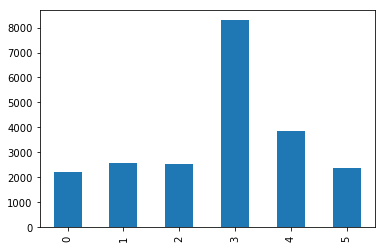

In [35]:
y_over_df =pd.DataFrame(y_over)

y_over_df[0].value_counts().sort_index().plot(kind ='bar')

In [36]:
y_over_df[0].value_counts().sort_index()

0    2236
1    2572
2    2544
3    8287
4    3867
5    2380
Name: 0, dtype: int64

In [37]:
X_over.shape

(21886, 50, 50, 3)

In [38]:
# Catgorise the y data
y_over_cat = to_categorical(y_over,6)

In [39]:
model =create_model()
model.fit(X_over,
         y_over_cat,
         batch_size=64,
         epochs=10,
         validation_data=(X_valid, y_valid))

y_pred = model.predict_classes(X_test)
y_cat= to_categorical(y_pred,6)
print(f"Accuracy: {accuracy_score(y_cat,y_test)}")
print(f"Classification Report: \n{classification_report(y_cat,y_test)}")

Train on 21886 samples, validate on 500 samples
Epoch 1/10
21886/21886 [==============================] - 24s 1ms/step - loss: 1.1136 - acc: 0.5671 - val_loss: 0.8309 - val_acc: 0.6880A: 12s -  - ETA: 2s - loss: 1.1416 - ac - ETA: 
Epoch 2/10
21886/21886 [==============================] - 22s 990us/step - loss: 0.8463 - acc: 0.6726 - val_loss: 0.7465 - val_acc: 0.7260
Epoch 3/10
21886/21886 [==============================] - 22s 996us/step - loss: 0.7476 - acc: 0.7076 - val_loss: 0.7165 - val_acc: 0.7160 6s - loss: 0.7531 - - ETA: 5s - loss - ETA: 4s - loss - ETA: 3s - loss: 0.7501 - ETA: 2s - loss: 0.7 - ETA: 1s - loss: 0.7
Epoch 4/10
21886/21886 [==============================] - 22s 992us/step - loss: 0.6952 - acc: 0.7279 - val_loss: 0.7105 - val_acc: 0.73204s -  - ETA: 3s - loss: 0 - ETA: 2s - lo - ETA: 0s - loss: 0.6953 - acc
Epoch 5/10
21886/21886 [==============================] - 24s 1ms/step - loss: 0.6513 - acc: 0.7446 - val_loss: 0.6954 - val_acc: 0.7300
Epoch 6/10
21886/218

When comparing the results of the first augmentation of the images there is a small improvement to the overall accuracy from 0.709 to 0.74. Class 1 and 4 saw a small reduction in f1-score. while all of the other classes saw improvement especially class 2 due to the tripple augmentation.

## Combination of Over and Undersampling model

In [40]:
X_OU,y_OU = reduce_majority(X_over,y_over,cls=3)

In [41]:
X_OU.shape,y_OU.shape

((17742, 50, 50, 3), (17742,))

In [42]:
y_OU_df =pd.DataFrame(y_OU)
y_OU_df[0].value_counts().sort_index()

0    2236
1    2572
2    2544
3    4143
4    3867
5    2380
Name: 0, dtype: int64

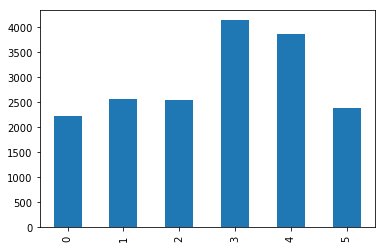

In [43]:
y_OU_df[0].value_counts().sort_index().plot(kind ='bar')

After the Augmentation and Undersampling of the majority class there is a much smaller difference between all of the classes.

In [44]:
# Catgorise the y data
y_OU_cat = to_categorical(y_OU,6)

In [45]:
model =create_model()
model.fit(X_OU,
         y_OU_cat,
         batch_size=64,
         epochs=10,
         validation_data=(X_valid, y_valid))

y_pred = model.predict_classes(X_test)
y_cat= to_categorical(y_pred,6)
print(f"Accuracy: {accuracy_score(y_cat,y_test)}")
print(f"Classification Report: \n{classification_report(y_cat,y_test)}")

Train on 17742 samples, validate on 500 samples
Epoch 1/10
17742/17742 [==============================] - 18s 1ms/step - loss: 1.2307 - acc: 0.5048 - val_loss: 0.8673 - val_acc: 0.6820
Epoch 2/10
17742/17742 [==============================] - 16s 917us/step - loss: 0.9063 - acc: 0.6367 - val_loss: 0.8443 - val_acc: 0.6620
Epoch 3/10
17742/17742 [==============================] - 16s 917us/step - loss: 0.8011 - acc: 0.6807 - val_loss: 0.7253 - val_acc: 0.7320
Epoch 4/10
17742/17742 [==============================] - 16s 912us/step - loss: 0.7371 - acc: 0.7074 - val_loss: 0.6887 - val_acc: 0.7240
Epoch 5/10
17742/17742 [==============================] - 16s 907us/step - loss: 0.6852 - acc: 0.7261 - val_loss: 0.6832 - val_acc: 0.7140
Epoch 6/10
17742/17742 [==============================] - 16s 930us/step - loss: 0.6407 - acc: 0.7468 - val_loss: 0.6577 - val_acc: 0.7480TA: 4s - - ETA: 2s - loss: 0.6402 - acc: 0.746 - ETA: 2s - loss: 0.6399 - acc: 0.746 - ET
Epoch 7/10
17742/17742 [=======

When combinining the undersampled and oversampled datasets there is a drop in accuracy, avg/total precision,recall and f1-score.

The two models that achived the best accuracy for the given test data were the Undersmapled and initial Augmented  oversampled model.